In [1]:
import os
os.chdir('/userdata/xueqwang/ArtPrice/ArtAuction')

from DataPrep.AuctionDataset import *

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from Models.NN import *

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

/userdata/xueqwang/miniconda3/envs/py_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib
import Models.NN
importlib.reload(Models.NN)
from Models.NN import *

## INPUTS

In [3]:
MODEL_NAME = 'NN_w_emb_res_MSE'
DATASET = 'all_data_dataprep_refined'
CLIP_UPPER = 25
SPLIT_QUANTILES = [0.1, 0.5, 0.9]

In [4]:
model_dict = {'NN_w_emb_res_Quartic':NeuralNet_w_emb_res,'NN_w_emb_res_MSE':NeuralNet_w_emb_res, 'NN_w_emb_res_WeightedMSE':NeuralNet_w_emb_res, 'NN_w_emb_bert_res_WeightedMSE':NeuralNet_w_emb_bert_res, 'NN_w_emb_bert_res_MSE': NeuralNet_w_emb_bert_res}
DATASET_FOLDER = 'dataprep_refined' if DATASET=='all_data_dataprep_refined' else ''

In [5]:
# os.makedirs(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}', exist_ok = True)

# Computation

## Load Data

In [6]:
raw_data_folder = 'Datasets'
periods_year = [1400, 1600, 1750, 1850, 1950, 1970, 2025]
birth_periods = [f'before_{y}' for y in periods_year]
auction_data = AuctionDataset(raw_data_folder, periods_year)
auction_data.cleaning()
auction_data.categorical_variables_grouping()

filter_con = auction_data.auction_results_filtered['Sale Year'].notnull()
filter_con = filter_con & auction_data.auction_results_filtered['Price Sold USD'].notnull()
filter_con = filter_con & auction_data.auction_results_filtered['Cumulative Sales'] > 0

auction_results_modelling = auction_data.auction_results_filtered[filter_con].copy()
auction_results_modelling.reset_index(drop=True, inplace=True)
auction_results_modelling['Log Average Historical Price'] = np.log(auction_results_modelling['Average Historical Price'].fillna(1))
auction_results_modelling['Log Cumulative Sales'] = np.log(auction_results_modelling['Cumulative Sales'])
auction_results_modelling['Log Price Sold USD'] = np.log(auction_results_modelling['Price Sold USD'])


cat_cols = ['Paint','Material','Auction House','Sale Location','Country']
# num_cols = ['Area_log','Cumulative Auction Count','CPI_US','Log Cumulative Sales','Alive_Yes','Alive_No','Prev Bought In','Repeated Sale','Prev Unknown'] + birth_periods + ['Log Average Historical Price']
num_cols = ['Area_log','Cumulative Auction Count','CPI_US','Log Cumulative Sales','Alive_Yes','Alive_No',] + birth_periods + ['Log Average Historical Price']
target_col = ['Log Price Sold USD']

con_train = auction_results_modelling['Sale Year'] <= 2014
con_val = (auction_results_modelling['Sale Year'] > 2014)&(auction_results_modelling['Sale Year'] <= 2018)
con_test = (auction_results_modelling['Sale Year'] > 2018)&(auction_results_modelling['Sale Year'] <= 2025)
# around 74%, 15%, 11%

# Encode categorical values
labelencoders = {}
for c in cat_cols:
    le = LabelEncoder()
    le.fit(auction_results_modelling.loc[con_train, c])
    labelencoders[c] = le

# Mean and Std of numerical values (excl. 0/1 indicators)
standardize_cols = ['Area_log','Cumulative Auction Count','CPI_US','Log Average Historical Price','Log Cumulative Sales']
standardize_means = auction_results_modelling.loc[con_train, standardize_cols].mean().to_dict()
standardize_stds = auction_results_modelling.loc[con_train, standardize_cols].std().to_dict()

# Target Quantiles (train): for weighted MSE
b_lower = torch.tensor(auction_results_modelling.loc[con_train, target_col].quantile(0.15))
b_upper = torch.tensor(auction_results_modelling.loc[con_train, target_col].quantile(0.85))

auction_data_train = AuctionDatasetNN(auction_results_modelling.loc[con_train, cat_cols + ['Artist ID'] + num_cols + target_col], standardize_means, standardize_stds, labelencoders, num_cols)
auction_data_val = AuctionDatasetNN(auction_results_modelling.loc[con_val, cat_cols + ['Artist ID'] + num_cols + target_col], standardize_means, standardize_stds, labelencoders, num_cols)
auction_data_test = AuctionDatasetNN(auction_results_modelling.loc[con_test, cat_cols + ['Artist ID'] + num_cols + target_col], standardize_means, standardize_stds, labelencoders, num_cols)
    
auction_data_train_loader = DataLoader(auction_data_train, batch_size=64, shuffle=False)
auction_data_val_loader = DataLoader(auction_data_val, batch_size=64, shuffle=False)
auction_data_test_loader = DataLoader(auction_data_test, batch_size=64, shuffle=False)

In [9]:
if os.path.exists('Datasets/artist_biography_bert_embedding.pt'):
    print("Embeddings found")
    biography_encoded = torch.load('Datasets/artist_biography_bert_embedding.pt')
else:
    biography_encoded = biography_embedding(auction_data.artists_details_df, device)

Embeddings found


## Load Model

In [12]:
# model_cp = torch.load(f'Model Checkpoints/{DATASET}/{MODEL_NAME}.pth')
model_cp = torch.load(f'{MODEL_NAME}.pth')

ffn_sizes = model_cp['metadata'].get('FFN_LAYER_SIZE', [512, 128, 128, 64] if MODEL_NAME == 'NN_w_emb_bert_res_WeightedMSE' else [128, 128, 64])

In [13]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_dict[MODEL_NAME](labelencoders, num_cols, ffn_sizes).to(device)
model.load_state_dict(model_cp['model_state_dict'])


<All keys matched successfully>

## Evaluate

In [14]:
model.eval()

y_pred_test = np.array([])
with torch.no_grad():
    for fea_cat, fea_num, artist_biography, log_price in auction_data_test_loader:
        fea_cat = fea_cat.to(device)
        fea_num = fea_num.to(device)
        log_price = log_price.to(device)

        output = model(fea_cat, fea_num, artist_biography, biography_encoded)

        # y_true_test = np.concatenate((y_true_test, np.array(log_price.detach().cpu().squeeze())))
        y_pred_test = np.concatenate((y_pred_test, np.array(output.detach().cpu().squeeze())))

In [16]:
auction_data_test.df['Log Price Pred'] = y_pred_test

# quantile_cutoffs = [auction_data_train.df[target_col[0]].quantile(q) for q in SPLIT_QUANTILES]
quantile_cutoffs = [auction_data_test.df[target_col[0]].quantile(q) for q in SPLIT_QUANTILES]
quantile_cutoffs.append(9999)
quantile_names = ['1 LOW','2 MID-LOW','3 MID-HIGH','4 HIGH']

In [19]:
pred_col_name = 'Log Price Pred'
target_col_name = 'Log Price Sold USD'

auction_data_test.df['delta_log'] = auction_data_test.df[pred_col_name] - auction_data_test.df[target_col_name]
auction_data_test.df['Price_ori'] = np.exp(auction_data_test.df[target_col_name])
auction_data_test.df['delta_ori'] = np.exp(auction_data_test.df[pred_col_name]) - auction_data_test.df['Price_ori']
auction_data_test.df['delta_perc_ori'] = 100*auction_data_test.df['delta_ori']/auction_data_test.df['Price_ori']

for q, r in zip(reversed(quantile_cutoffs), reversed(quantile_names)):
    auction_data_test.df.loc[auction_data_test.df[target_col_name]<=q, 'RANGE'] = r

In [20]:
auction_data_test.df['Covered_in_pm_20%'] = ((auction_data_test.df['Price_ori']/np.exp(auction_data_test.df['Log Price Pred'])-1).abs()<=0.2).astype(int)
auction_data_test.df['Covered_in_pm_50%'] = ((auction_data_test.df['Price_ori']/np.exp(auction_data_test.df['Log Price Pred'])-1).abs()<=0.5).astype(int)

auction_data_test.df.groupby('RANGE')[['Covered_in_pm_20%','Covered_in_pm_50%']].mean()

,Covered_in_pm_20%,Covered_in_pm_50%
RANGE,,
1 LOW,0.118186,0.355578
2 MID-LOW,0.190288,0.478970
3 MID-HIGH,0.127104,0.324452
4 HIGH,0.092253,0.215087


In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [25]:
[
    r2_score(auction_data_test.df[target_col_name], auction_data_test.df[pred_col_name]),
    mean_squared_error(auction_data_test.df[target_col_name], auction_data_test.df[pred_col_name], squared=False),
    mean_absolute_percentage_error(auction_data_test.df[target_col_name], auction_data_test.df[pred_col_name]),
    mean_absolute_percentage_error(auction_data_test.df['Price_ori'], np.exp(auction_data_test.df[pred_col_name]))
]

[0.610191006265808, 1.22998018583118, 0.09088011918514638, 1.4412181647568496]

In [27]:
model.eval()

# y_true_val = np.array([])
y_pred_val = np.array([])
with torch.no_grad():
    for fea_cat, fea_num, artist_biography, log_price in auction_data_val_loader:
        fea_cat = fea_cat.to(device)
        fea_num = fea_num.to(device)
        log_price = log_price.to(device)

        output = model(fea_cat, fea_num, artist_biography, biography_encoded)

        # y_true_val = np.concatenate((y_true_val, np.array(log_price.detach().cpu().squeeze())))
        y_pred_val = np.concatenate((y_pred_val, np.array(output.detach().cpu().squeeze())))


# y_true_test = np.array([])
y_pred_test = np.array([])
with torch.no_grad():
    for fea_cat, fea_num, artist_biography, log_price in auction_data_test_loader:
        fea_cat = fea_cat.to(device)
        fea_num = fea_num.to(device)
        log_price = log_price.to(device)

        output = model(fea_cat, fea_num, artist_biography, biography_encoded)

        # y_true_test = np.concatenate((y_true_test, np.array(log_price.detach().cpu().squeeze())))
        y_pred_test = np.concatenate((y_pred_test, np.array(output.detach().cpu().squeeze())))

## Prediction Errors

In [28]:
auction_data_val.df['Log Price Pred'] = y_pred_val
auction_data_test.df['Log Price Pred'] = y_pred_test

In [29]:
# quantile_cutoffs = [auction_data_train.df[target_col[0]].quantile(q) for q in SPLIT_QUANTILES]
quantile_cutoffs = [auction_data_test.df[target_col[0]].quantile(q) for q in SPLIT_QUANTILES]
quantile_cutoffs.append(9999)
quantile_names = ['1 LOW','2 MID-LOW','3 MID-HIGH','4 HIGH']

In [30]:
def evaluation_summary(df_val, df_test, 
                       target_col_name, pred_col_name, 
                       fig_save_to = None,
                       clip_upper = 25, 
                       quantile_cutoffs=[6.796823718274855, 8.57866451350434, 11.118023371247016, 9999],
                       quantile_names = ['1 LOW','2 MID-LOW','3 MID-HIGH','4 HIGH']):
    
    df_val['delta_log'] = df_val[pred_col_name] - df_val[target_col_name]
    df_val['Price_ori'] = np.exp(df_val[target_col_name])
    df_val['delta_ori'] = np.exp(df_val[pred_col_name].clip(upper = clip_upper)) - df_val['Price_ori']
    df_val['delta_perc_ori'] = 100*df_val['delta_ori']/df_val['Price_ori']

    df_test['delta_log'] = df_test[pred_col_name] - df_test[target_col_name]
    df_test['Price_ori'] = np.exp(df_test[target_col_name])
    df_test['delta_ori'] = np.exp(df_test[pred_col_name].clip(upper = clip_upper)) - df_test['Price_ori']
    df_test['delta_perc_ori'] = 100*df_test['delta_ori']/df_test['Price_ori']

    for q, r in zip(reversed(quantile_cutoffs), reversed(quantile_names)):
        df_val.loc[df_val[target_col_name]<=q, 'RANGE'] = r
        df_test.loc[df_test[target_col_name]<=q, 'RANGE'] = r

    outlier_con_val = df_val[pred_col_name] > clip_upper
    outlier_con_test = df_test[pred_col_name] > clip_upper

    mae_log_val = mean_absolute_error(df_val.loc[~outlier_con_val, target_col_name], df_val.loc[~outlier_con_val,pred_col_name])
    mae_log_test = mean_absolute_error(df_test.loc[~outlier_con_test, target_col_name], df_test.loc[~outlier_con_test,pred_col_name])
    mae_ori_val = mean_absolute_error(df_val.loc[~outlier_con_val, 'Price_ori'], np.exp(df_val.loc[~outlier_con_val, 'Log Price Pred']))
    mae_ori_test = mean_absolute_error(df_test.loc[~outlier_con_test, 'Price_ori'], np.exp(df_test.loc[~outlier_con_test, 'Log Price Pred']))
    mae_summary = pd.DataFrame({'log scale':[mae_log_val, mae_log_test], 'original scale':[mae_ori_val, mae_ori_test]}, index=['validation','test'])

    val_eval = df_val[~outlier_con_val].groupby('RANGE').apply(
        lambda x: pd.Series(
            {
                'Average Price': x['Price_ori'].mean(),
                'MAE':mean_absolute_error(x['Price_ori'], np.exp(x['Log Price Pred'])),
                'MAE (log)':mean_absolute_error(x[target_col_name], x['Log Price Pred']),
                'Average Delta (%)': x['delta_perc_ori'].mean(),
                '+- 20%': (x['delta_perc_ori'].abs()<=20).mean(),
                '+- 50%': (x['delta_perc_ori'].abs()<=50).mean(),
                '+- 80%': (x['delta_perc_ori'].abs()<=80).mean(),
            }
        )
    )
    test_eval = df_test[~outlier_con_test].groupby('RANGE').apply(
        lambda x: pd.Series(
            {
                'Average Price': x['Price_ori'].mean(),
                'MAE':mean_absolute_error(x['Price_ori'], np.exp(x['Log Price Pred'])),
                'MAE (log)':mean_absolute_error(x[target_col_name], x['Log Price Pred']),
                'Average Delta (%)': x['delta_perc_ori'].mean(),
                '+- 20%': (x['delta_perc_ori'].abs()<=20).mean(),
                '+- 50%': (x['delta_perc_ori'].abs()<=50).mean(),
                '+- 80%': (x['delta_perc_ori'].abs()<=80).mean(),
            }
        )
    )

    sns.set_theme(style='white')

    fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey='row')
    sns.boxplot(data = df_val[~outlier_con_val], x = 'RANGE', y='delta_log', order=quantile_names, ax=axes[0,0])
    sns.boxplot(data = df_test[~outlier_con_test], x = 'RANGE', y='delta_log', order=quantile_names, ax=axes[0,1])
    axes[0,0].set_title('Validation')
    axes[0,0].set_xlabel("")
    axes[0,0].set_ylabel("Prediction Errors of Log Price")
    axes[0,1].set_title('Test')
    axes[0,1].set_xlabel("")

    df_val['delta_perc_ori_abs'] = df_val['delta_perc_ori'].abs()
    df_test['delta_perc_ori_abs'] = df_test['delta_perc_ori'].abs()
    sns.histplot(data = df_val[~outlier_con_val], x='delta_perc_ori_abs', hue='RANGE', hue_order=quantile_names, element='step', fill=False, cumulative=True, stat='probability', common_norm=False, ax=axes[1,0])
    sns.histplot(data = df_test[~outlier_con_test], x='delta_perc_ori_abs', hue='RANGE', hue_order=quantile_names, element='step', fill=False, cumulative=True, stat='probability', common_norm=False, ax=axes[1,1])
    axes[1,0].set_xlim([0,300])
    axes[1,0].set_xlabel("%Prediction Errors of Price")
    axes[1,0].set_ylabel("Cumulative Probability")
    axes[1,1].set_xlim([0,300])
    axes[1,1].set_xlabel("%Prediction Errors of Price")
    axes[1,0].grid(True)
    axes[1,1].grid(True)
    
    if fig_save_to:
        plt.savefig(fig_save_to)

    plt.show()

    return mae_summary, val_eval, test_eval, df_val, df_test

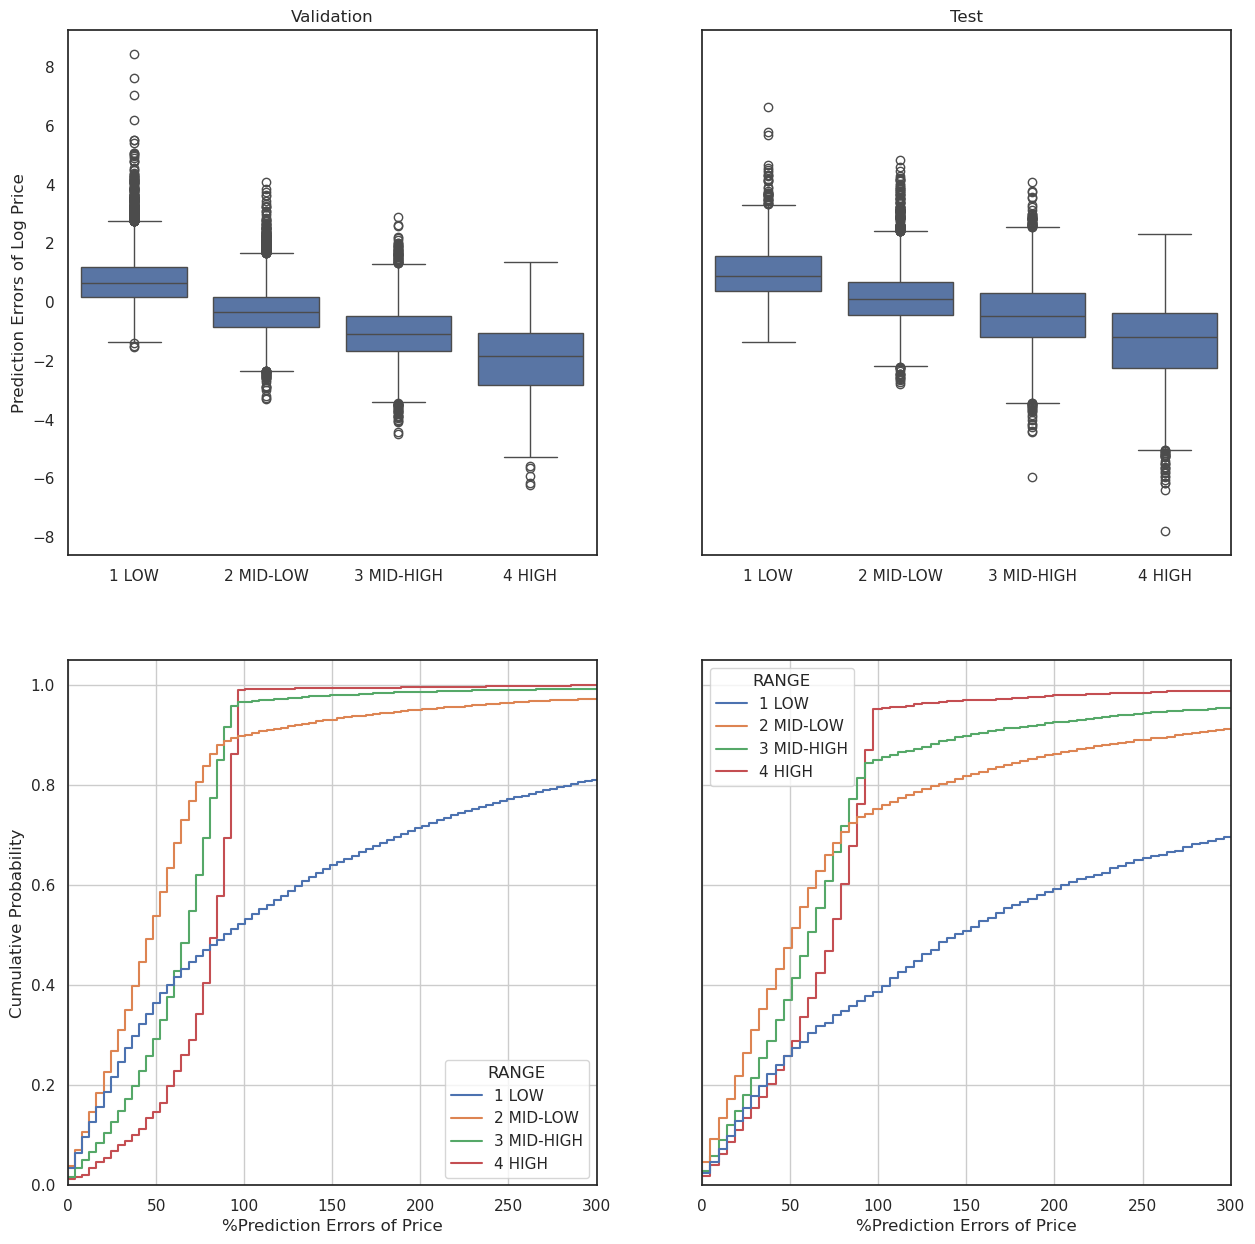

In [31]:
# 'Models Evaluation/dataprep_refined/{MODEL_NAME}/plots.png'
mae_summary, val_eval, test_eval, df_val, df_test = evaluation_summary(
    auction_data_val.df, auction_data_test.df, 'Log Price Sold USD', 'Log Price Pred',
    # fig_save_to = f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/plots.png',
    quantile_cutoffs = quantile_cutoffs,
    )

auction_data_val.df = df_val.copy()
auction_data_test.df = df_test.copy()

del df_val, df_test

In [32]:
print(mae_summary)
print(val_eval)
print(test_eval)

            log scale  original scale
validation   0.875338    98545.611828
test         0.935430   342751.920107
            Average Price           MAE  MAE (log)  Average Delta (%)  \
RANGE                                                                   
1 LOW        1.400809e+03  2.100071e+03   0.856221         310.271728   
2 MID-LOW    1.047521e+04  7.185890e+03   0.685633           7.228427   
3 MID-HIGH   1.001278e+05  7.040994e+04   1.187127         -44.997730   
4 HIGH       3.741386e+06  3.204622e+06   1.992968         -71.241240   

              +- 20%    +- 50%    +- 80%  
RANGE                                     
1 LOW       0.156072  0.351456  0.468488  
2 MID-LOW   0.183354  0.511743  0.834446  
3 MID-HIGH  0.083721  0.269395  0.686326  
4 HIGH      0.046667  0.136000  0.394667  
            Average Price           MAE  MAE (log)  Average Delta (%)  \
RANGE                                                                   
1 LOW        1.845423e+03  5.803354e+03   1

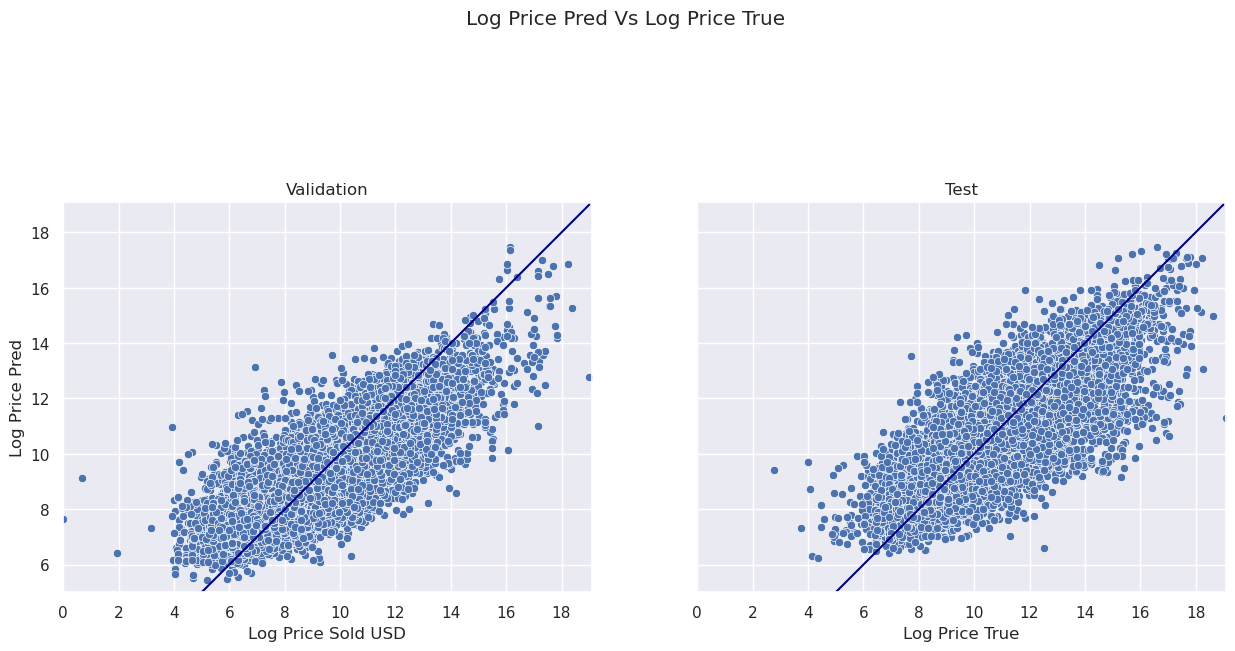

In [22]:
x_min = min(auction_data_val.df['Log Price Sold USD'].min(), auction_data_test.df['Log Price Sold USD'].min(), auction_data_val.df['Log Price Pred'].min(), auction_data_test.df['Log Price Pred'].min())
x_max = max(auction_data_val.df['Log Price Sold USD'].max(), auction_data_test.df['Log Price Sold USD'].max(), auction_data_val.df['Log Price Pred'].max(), auction_data_test.df['Log Price Pred'].max())

x_line = np.arange(x_min, x_max, 0.1)

sns.set_theme()

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.scatterplot(data=auction_data_val.df, x='Log Price Sold USD', y='Log Price Pred', ax=axes[0])
sns.lineplot(x=x_line, y=x_line, ax=axes[0], color = 'navy')
axes[0].set_title('Validation')

sns.scatterplot(data=auction_data_test.df, x='Log Price Sold USD', y='Log Price Pred', ax=axes[1])
sns.lineplot(x=x_line, y=x_line, ax=axes[1], color = 'navy')
axes[1].set_title('Test')


for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(5, x_max)
    ax.set_xticks(np.arange(x_min, x_max, 2))
    ax.set_aspect('equal')

# # plt.grid(True)
plt.xlabel('Log Price True')
plt.ylabel('Log Price Pred')
plt.suptitle('Log Price Pred Vs Log Price True')

plt.savefig(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/True_v_Pred.png')

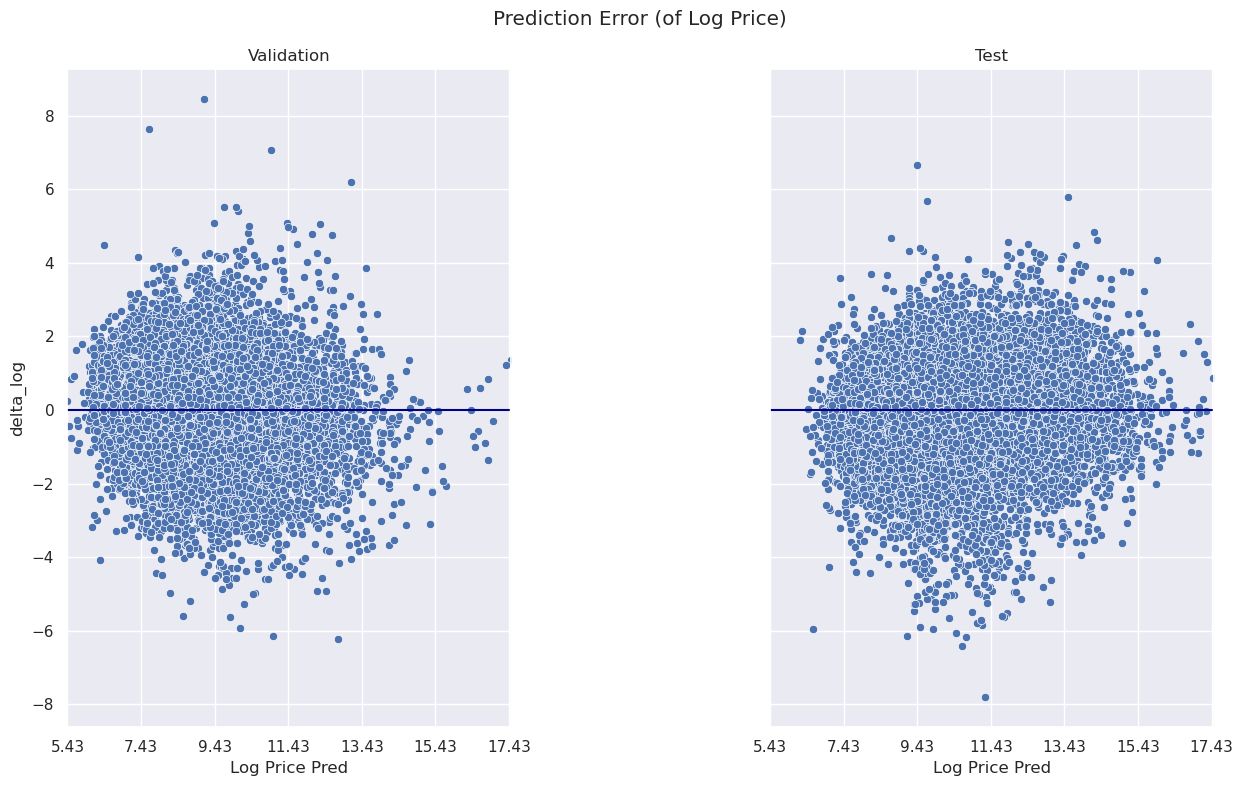

In [23]:
x_min = min(auction_data_val.df['Log Price Pred'].min(), auction_data_test.df['Log Price Pred'].min())
x_max = max(auction_data_val.df['Log Price Pred'].max(), auction_data_test.df['Log Price Pred'].max())

x_line = np.arange(x_min, x_max, 0.1)

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.set_theme()

sns.scatterplot(data=auction_data_val.df, x='Log Price Pred', y='delta_log', ax=axes[0])
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[0], color = 'navy')
axes[0].set_title('Validation')
# axes[0].set_aspect('equal')

sns.scatterplot(data=auction_data_test.df, x='Log Price Pred', y='delta_log', ax=axes[1])
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[1], color = 'navy')
axes[1].set_title('Test')
# axes[1].set_aspect('equal')

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(x_min, x_max, 2))

# # plt.grid(True)
plt.xlabel('Log Price Pred')
plt.ylabel('Error')
plt.suptitle('Prediction Error (of Log Price)')
plt.tight_layout()

plt.savefig(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/Err_v_Pred.png')
plt.show()

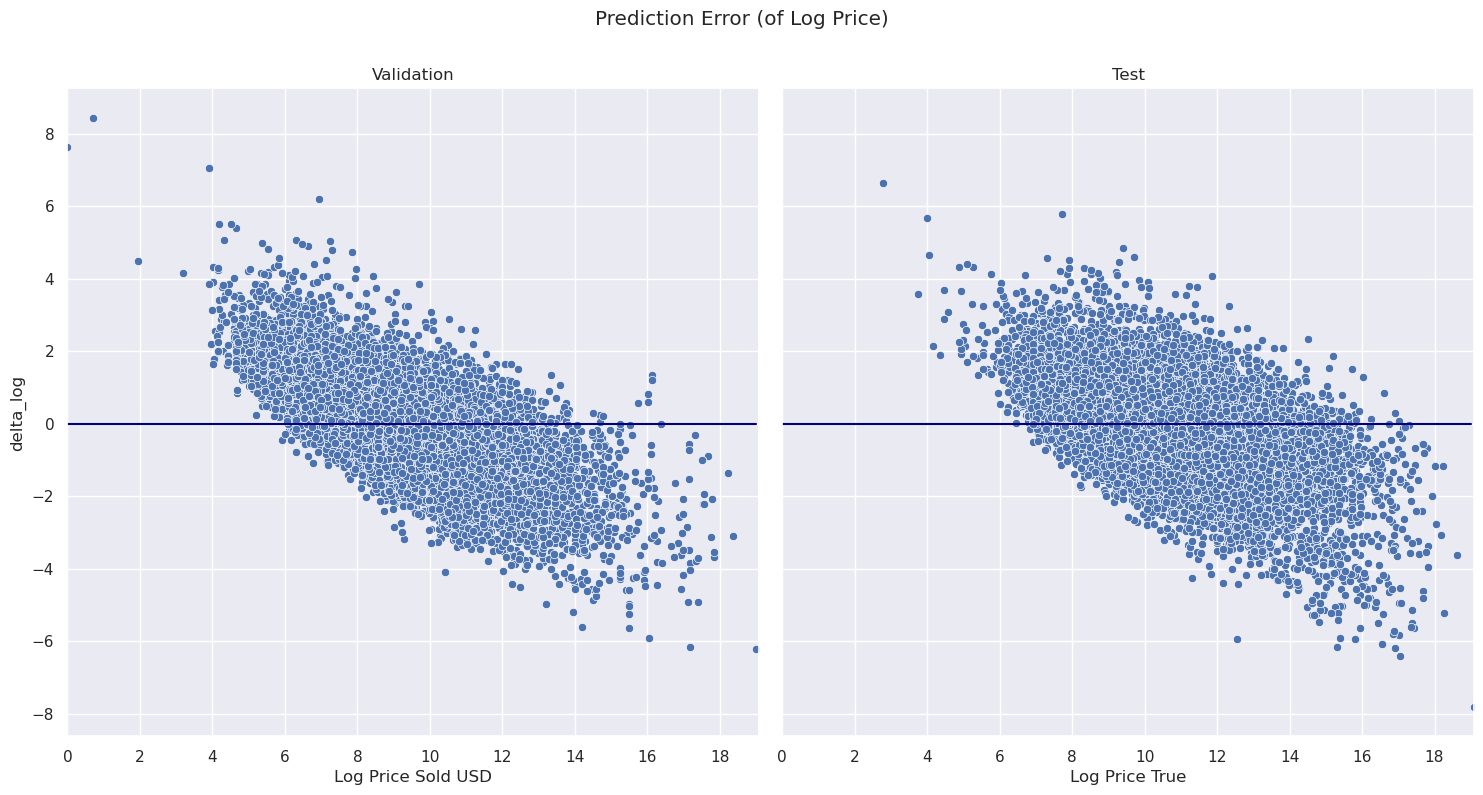

In [24]:
x_min = min(auction_data_val.df[target_col[0]].min(), auction_data_test.df[target_col[0]].min())
x_max = max(auction_data_val.df[target_col[0]].max(), auction_data_test.df[target_col[0]].max())

x_line = np.arange(x_min, x_max, 0.1)

fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
sns.set_theme()

sns.scatterplot(data=auction_data_val.df, x=target_col[0], y='delta_log', ax=axes[0])
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[0], color = 'navy')
axes[0].set_title('Validation')
# axes[0].set_aspect('equal')

sns.scatterplot(data=auction_data_test.df, x=target_col[0], y='delta_log', ax=axes[1])
line_x = np.arange(auction_data_test.df[target_col[0]].min(), auction_data_test.df[target_col[0]].max(), 0.1)
sns.lineplot(x=x_line, y=[0]*len(x_line), ax=axes[1], color = 'navy')
axes[1].set_title('Test')
# axes[1].set_aspect('equal')

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(x_min, x_max, 2))

# # plt.grid(True)
plt.xlabel('Log Price True')
plt.ylabel('Error')
plt.suptitle('Prediction Error (of Log Price)')
plt.tight_layout()

plt.savefig(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/Err_v_True.png')
plt.show()

In [25]:
with open(f'Models Evaluation/{DATASET_FOLDER}/{MODEL_NAME}/Summary.html', 'w') as f:
    f.write(f"<h2>Metadata</h2><p>{model_cp['metadata']}</p>")
    f.write(f"<h2>MAE Summary</h2><p>{mae_summary.to_html(index=True)}</p>")
    f.write(f"<h2>Validation Evaluation</h2><p>{val_eval.to_html(index=True)}</p>")
    f.write(f"<h2>Test Evaluation</h2><p>{test_eval.to_html(index=True)}</p>")
    # f.write(f"<h2>Plot</h2><img src='plots.png'>")
    f.write(f"<h2>Plots</h2>")
    f.write(f"<img src='plots.png' style='width:600px'><br>")
    f.write(f"<img src='True_v_Pred.png' style='width:600px'><br>")
    f.write(f"<img src='Err_v_True.png' style='width:600px'><br>")
    f.write(f"<img src='Err_v_Pred.png' style='width:600px'><br>")

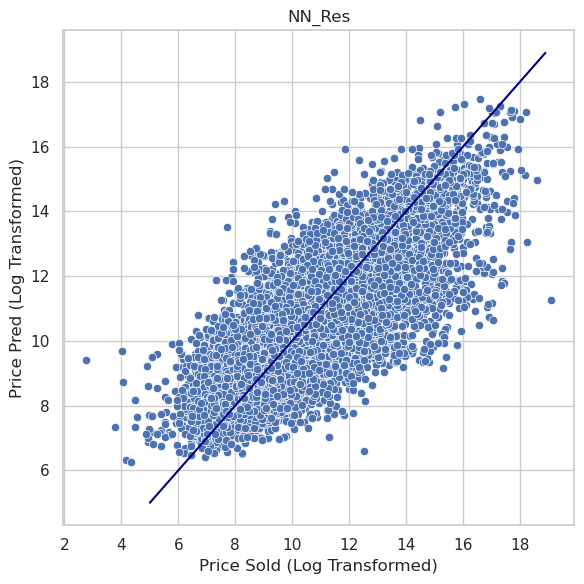

In [32]:
sns.set_theme('notebook')
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
sns.scatterplot(data=auction_data_test.df, x='Log Price Sold USD', y='Log Price Pred')
x_line = np.arange(5, 19, 0.1)
sns.lineplot(x=x_line, y=x_line, color = 'navy')
plt.xlabel('Price Sold (Log Transformed)')
plt.ylabel('Price Pred (Log Transformed)')
plt.title('NN_Res')
plt.tight_layout()

In [ ]:
auction_data_test.df['Covered_in_pm_20%'] = ((auction_data_test.df['Price_ori']/np.exp(auction_data_test.df['Log Price Pred'])-1).abs()<=0.2).astype(int)
auction_data_test.df['Covered_in_pm_50%'] = ((auction_data_test.df['Price_ori']/np.exp(auction_data_test.df['Log Price Pred'])-1).abs()<=0.5).astype(int)

auction_data_test.df.groupby('RANGE')[['Covered_in_pm_20%','Covered_in_pm_50%']].mean()

In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(auction_data_test.df['Log Price Sold USD'], auction_data_test.df['Log Price Pred'], squared=False)

1.22998018583118

In [41]:
from sklearn.metrics import r2_score
r2_score(auction_data_test.df['Log Price Sold USD'], auction_data_test.df['Log Price Pred'])

0.610191006265808

In [42]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(auction_data_test.df['Log Price Sold USD'], auction_data_test.df['Log Price Pred'])

0.09088011918514638

In [44]:
((auction_data_test.df['Log Price Sold USD'] - auction_data_test.df['Log Price Pred']).abs()/(auction_data_test.df['Log Price Sold USD'] + auction_data_test.df['Log Price Pred'])).mean()

0.04538311608962388

# OPTIONAL - ANALYZE EMBEDDINGS

In [83]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px

In [101]:
cat_col_idx = 3

model_cp['model_state_dict'][f'cat_embeddings.{cat_col_idx}.weight'].shape # Paint


torch.Size([36, 18])

In [102]:
labelencoders.keys()

dict_keys(['Paint', 'Material', 'Auction House', 'Sale Location', 'Country'])

In [103]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(model_cp['model_state_dict'][f'cat_embeddings.{cat_col_idx}.weight'].cpu())

pca=PCA(n_components=5)
pca_result = pca.fit_transform(embeddings_scaled)

pca_result_df = pd.DataFrame(pca_result[:,:2], columns=['PC1','PC2'])
pca_result_df['CLASS'] = labelencoders[list(labelencoders.keys())[cat_col_idx]].classes_

pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_)

(array([0.13972969, 0.11664843, 0.09891309, 0.09134262, 0.08182816]),
 array([0.13972969, 0.25637812, 0.35529121, 0.44663382, 0.52846198]))

In [104]:
tsne = TSNE(n_components=2, perplexity=2, learning_rate=200, n_iter=1000, n_jobs=-1)
tsne_results = tsne.fit_transform(embeddings_scaled)

tsne_results_df = pd.DataFrame(tsne_results[:,:2], columns=['PC1','PC2'])
tsne_results_df['CLASS'] = labelencoders[list(labelencoders.keys())[cat_col_idx]].classes_

tsne_results_df['SAMPLE_SIZE'] = tsne_results_df['CLASS'].map(auction_results_modelling[con_train][list(labelencoders.keys())[cat_col_idx]].value_counts().to_dict())
tsne_results_df['LOG_SAMPLE_SIZE'] = np.log(tsne_results_df['SAMPLE_SIZE'])

/userdata/xueqwang/miniconda3/envs/py_env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



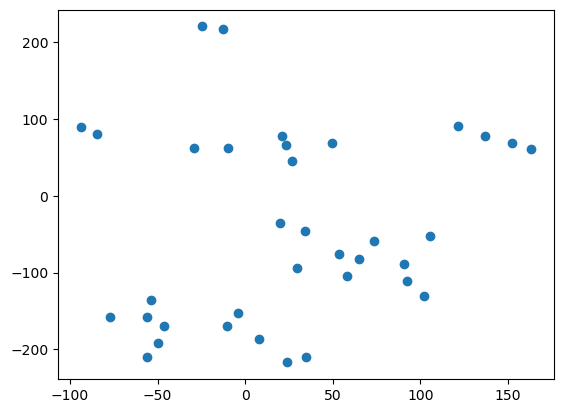

In [105]:
plt.scatter(tsne_results[:,0], tsne_results[:,1])

In [106]:
fig = px.scatter(
    tsne_results_df, 
    x='PC1', y='PC2', 
    hover_data={'CLASS': True, 'SAMPLE_SIZE':True}, 
    color='SAMPLE_SIZE', 
    width=800, height=800)
fig.update_traces(marker=dict(opacity=0.7))
fig.show()

# SHAP

In [39]:
import shap

shap.initjs()

In [40]:
if not hasattr(np, 'int'):
    np.int = int

In [41]:
import torch.nn as nn

In [42]:
class WrappedModel(nn.Module):
    def __init__(self, model, cat_size):
        super().__init__()
        self.model = model
        self.cat_size = cat_size  # number of categorical features

    def forward(self, X):
        # Split and cast
        X_cat = X[:, :self.cat_size].long()
        X_num = X[:, self.cat_size:]
        return self.model(X_cat, X_num, None, None)

In [51]:
train_sample = 500
val_sample = 500

X_train = auction_data_train.df.sample(n=train_sample, random_state=0)
X_val = auction_data_val.df.sample(n=val_sample, random_state=0)

X_train_cat = torch.tensor(X_train[labelencoders.keys()].values, dtype=torch.long).to(device)
X_train_num = torch.tensor(X_train[num_cols].values, dtype=torch.float32).to(device)
X_val_cat = torch.tensor(X_val[labelencoders.keys()].values, dtype=torch.long).to(device)
X_val_num = torch.tensor(X_val[num_cols].values, dtype=torch.float32).to(device)

In [52]:
X_val_combined = torch.cat([
    X_val_cat.float(),  # convert to float for SHAP
    X_val_num
], dim=1).to(device)

X_background_combined = torch.cat([
    X_train_cat.float(),
    X_train_num
], dim=1).to(device)

In [53]:
wrapped_model = WrappedModel(model, cat_size=X_val_cat.shape[1]).to(device)
wrapped_model.eval()

explainer = shap.DeepExplainer(wrapped_model, X_background_combined)
shap_values = explainer.shap_values(X_val_combined)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [54]:
combined_df = pd.concat([
    pd.DataFrame(X_val_cat.detach().cpu().numpy(), columns=labelencoders.keys()),
    pd.DataFrame(X_val_num.detach().cpu().numpy(), columns=num_cols)
], axis=1)

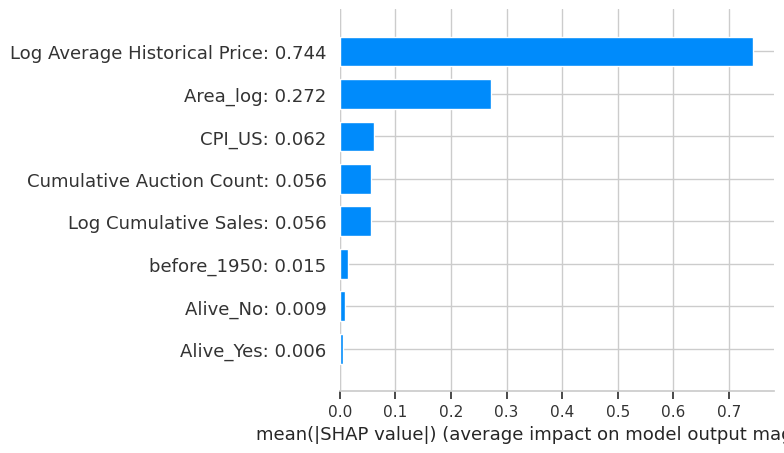

In [55]:
shap.summary_plot(shap_values, feature_names=[f'{c}: {np.round(s, decimals=3)}' for c, s in zip(list(combined_df.columns), np.abs(shap_values).mean(axis=0))], plot_type="bar", max_display=8)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


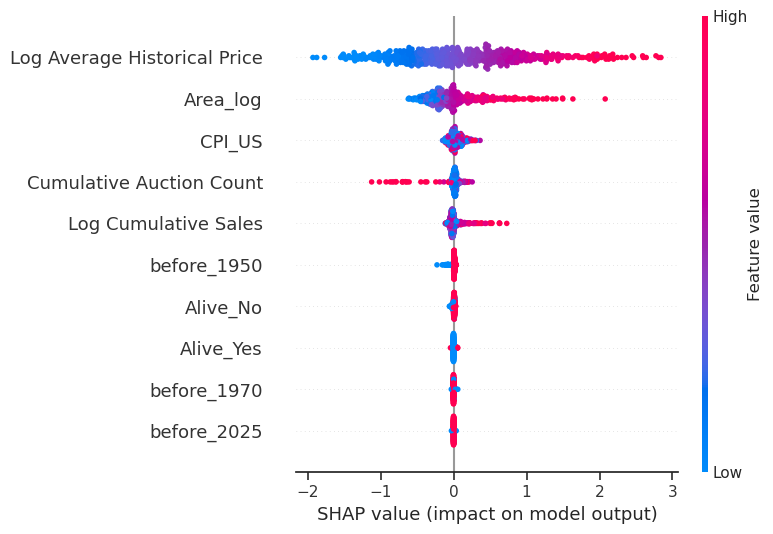

In [58]:
sns.set_style('white')
shap.summary_plot(shap_values, combined_df, feature_names=combined_df.columns, max_display=10)

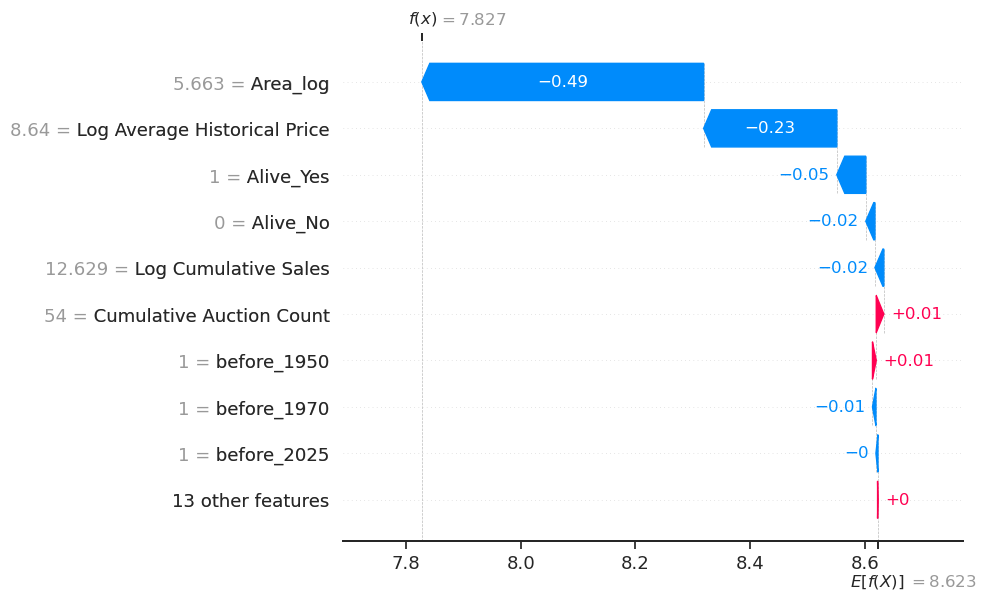

In [258]:
idx = 29
row_val_transformed = combined_df.iloc[idx].to_dict()
row_val_ori_w_shap = {}
shap_value_i = shap_values[idx]

for i, (p, v) in enumerate(row_val_transformed.items()):
    if p in labelencoders.keys():
        v_ori = {i: cat for i, cat in enumerate(labelencoders[p].classes_)}.get(v)
    elif p in standardize_cols:
        mu = standardize_means.get(p)
        std = standardize_stds.get(p)
        v_ori = np.round(v*std + mu, 3)
    else:
        v_ori = int(v)

    # row_val_ori_w_shap.update({p: [v_ori, shap_value_i[i]]})
    row_val_ori_w_shap.update({p: v_ori})
exp = shap.Explanation(
    values=shap_value_i,
    base_values = explainer.expected_value[0],
    data = list(row_val_ori_w_shap.values()),
    feature_names = list(row_val_ori_w_shap.keys())
)
shap.plots.waterfall(exp)